In [1]:
import torch.nn    as nn
import torch.optim as optim
import numpy       as np
import torch
import json
import os

from torch_geometric.data import Data

# Checking if pytorch can run in GPU, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
# Based on adding and removing noise to graphs
# The models is able to learn hidded patterns
# It can be conditionally trained with respect to some target property

In [4]:
# Define folder in which all data will be stored
data_name     = 'BiSI'
data_folder   = f'models/{data_name}'

# The folder is named as target_folder_vi (eg, target_folder_v0)
general_folder = f'models/{data_name}'
if not os.path.exists(general_folder):
    # Generate new folder
    os.system(f'mkdir {general_folder}')

# Each new run generates a new folder, with different generations and training most likely (as data might vary as well)
i = 0
while True:
    target_folder = f'{general_folder}/GM_v{i}'
    if not path.exists(target_folder):
        # Generate new folder
        os.system(f'mkdir {target_folder}')
        
        # Copy train-test data
        os.system(f'cp {data_folder}/train_dataset.pt             {target_folder}'
        os.system(f'cp {data_folder}/test_dataset.pt              {target_folder}'
        os.system(f'cp {data_folder}/standardized_parameters.json {target_folder}'

edge_model_name = f'{target_folder}/edge_model.pt'
node_model_name = f'{target_folder}/node_model.pt'

In [5]:
# Machine-learning parameters
n_epochs      = 3000
batch_size    = 32
learning_rate = 0.0001

# Number of diffusing and denoising steps
n_t_steps = 100

# Decay of parameter alpha
noise_contribution = 0.05
alpha_decay = 0.5 * (1 - noise_contribution**2)

# Dropouts for node and edge models (independent of each other)
dropout_node = 0.2
dropout_edge = 0.2

# Create and save as a dictionary
model_parameters = {
    'data_folder':        data_folder,
    'n_epochs':           n_epochs,
    'batch_size':         batch_size,
    'learning_rate':      learning_rate,
    'test_ratio':         test_ratio,
    'n_t_steps':          n_t_steps,
    'noise_contribution': noise_contribution,
    'dropout_node':       dropout_node,
    'dropout_edge':       dropout_edge
}

# Write the dictionary to the file in JSON format
with open(f'{target_folder}/model_parameters.json', 'w') as json_file:
    json.dump(model_parameters, json_file)

# Load of graph database for training

Load the dataset, already standarized.

In [9]:
train_dataset_name_std      = f'{target_folder}/train_dataset.pt'
test_dataset_name_std       = f'{target_folder}/test_dataset.pt'
dataset_parameters_name_std = f'{target_folder}/standardized_parameters.json'  # Parameters for rescaling the predictions

# Load the standardized dataset, with corresponding labels and parameters
train_dataset = torch.load(train_dataset_name_std)
test_dataset  = torch.load(test_dataset_name_std)

# Load the data from the JSON file
with open(dataset_parameters_name_std, 'r') as json_file:
    numpy_dict = json.load(json_file)

# Convert NumPy arrays back to PyTorch tensors
dataset_parameters = {key: torch.tensor(value) for key, value in numpy_dict.items()}

# Defining target factor
target_factor = dataset_parameters['target_std'] / dataset_parameters['scale']

Number of training graphs: 4186
Number of testing  graphs: 0


# Training of the model

In [10]:
# Determine number of features in dataset, considering the t_step information
n_features = dataset[0].num_node_features + 1

# Instantiate the models for nodes and edges
node_model = nGCNN(n_features, dropout_node).to(device)
edge_model = eGCNN(n_features, dropout_edge).to(device)

# Load previous model if available
try:
    node_model.load_state_dict(torch.load(node_model_name))
    edge_model.load_state_dict(torch.load(edge_model_name))
except FileNotFoundError:
    pass

# Evaluate model state
node_model.eval()
edge_model.eval()

print('\nNode GCNN:')
print(node_model)
print('\nEdge GCNN:')
print(edge_model)


Node GCNN:
nGCNN(
  (conv1): GraphConv(5, 256)
  (conv2): GraphConv(256, 5)
)

Edge GCNN:
eGCNN(
  (linear1): Linear(in_features=6, out_features=64, bias=True)
  (linear2): Linear(in_features=64, out_features=1, bias=True)
)


In [21]:
# Loss factor for normalization
loss_factor = len(train_dataset) * n_t_steps

# Initialize the optimizers
node_optimizer = torch.optim.Adam(node_model.parameters(), lr=learning_rate)
edge_optimizer = torch.optim.Adam(edge_model.parameters(), lr=learning_rate)

# Training loop
total_losses = []
edge_losses  = []
node_losses  = []
for epoch in range(n_epochs):
    # Initialize train loss variable
    total_loss_cum = 0
    edge_loss_cum  = 0
    node_loss_cum  = 0
    for graph in train_dataset:
        #print()
        # Clone existing graph
        graph_0 = graph.clone()
        
        # Initialize the gradient of the optimizers
        node_optimizer.zero_grad()
        edge_optimizer.zero_grad()
        
        # Start denoising-diffusing process
        for t_step in np.arange(1, n_t_steps+1):
            # Diffuse the graph with some noise
            #print()
            #print(f'Step: {t_step}')
            #print('Diffusing...')
            
            graph_t, epsilon_t = diffusion_step(graph_0, t_step, n_t_steps, alpha_decay)
            
            # Update diffused graph as next one
            graph_0 = graph_t.clone()

            # Denoise the diffused graph
            #print(f'Denoising...')
            
            # Add t_step information to graph_t
            t_step_std = (t_step/n_t_steps - 0.5)  # Standard normalization
            graph_t = add_features_to_graph(graph_t,
                                            torch.tensor([[t_step_std]], dtype=torch.float))  # To match graph.y shape
            
            # Add target information
            #graph_t = add_features_to_graph(graph_t,
            #                                    graph_t.y)

            # Perform a single forward pass for predicting node features
            out_x = node_model(graph_t.x,
                               graph_t.edge_index,
                               graph_t.edge_attr)
            
            # Remove t_step information
            out_x = out_x[:, :-1]

            # Define x_i and x_j as features of every corresponding pair of nodes (same order than attributes)
            x_i = graph_t.x[graph_t.edge_index[0]]
            x_j = graph_t.x[graph_t.edge_index[1]]

            # Perform a single forward pass for predicting edge attributes
            # Introduce previous edge attributes as features as well
            out_attr = edge_model(x_i, x_j, graph_t.edge_attr)

            # Construct noise graph
            pred_epsilon_t = Data(x=out_x,
                                  edge_index=graph_t.edge_index,
                                  edge_attr=out_attr.ravel())
            
            # Backpropagation and optimization step
            #print('Backpropagating...')

            # Calculate the loss for node features and edge attributes
            node_loss, edge_loss = get_graph_losses(epsilon_t, pred_epsilon_t)
            
            # Backpropagate and optimize node loss
            node_loss.backward(retain_graph=True)
            node_optimizer.step()

            # Backpropagate and optimize edge loss
            edge_loss.backward(retain_graph=True)
            edge_optimizer.step()

            # Accumulate the total training loss
            loss = node_loss + edge_loss
            
            # Get items
            total_loss_cum += loss.item()
            edge_loss_cum  += edge_loss.item()
            node_loss_cum  += node_loss.item()
    
    # Compute the average train loss
    total_loss_cum = total_loss_cum / loss_factor
    edge_loss_cum  = edge_loss_cum  / loss_factor
    node_loss_cum  = node_loss_cum  / loss_factor
    
    # Append average losses
    total_losses.append(total_loss_cum)
    edge_losses.append(edge_loss_cum)
    node_losses.append(node_loss_cum)
    
    print(f'Epoch: {epoch+1}, total loss: {total_loss_cum:.4f}, edge loss: {edge_loss_cum:.4f}, node loss: {node_loss_cum:.4f}')
    
    # Save some checkpoints
    if (epoch % 20) == 0:
        torch.save(node_model.state_dict(), node_model_name)
        torch.save(edge_model.state_dict(), edge_model_name)

torch.save(node_model.state_dict(), node_model_name)
torch.save(edge_model.state_dict(), edge_model_name)

Epoch: 1, total loss: 57.1033, edge loss: 1.1463, node loss: 55.9570
Epoch: 2, total loss: 2.0026, edge loss: 1.0000, node loss: 1.0026
Epoch: 3, total loss: 1.9986, edge loss: 0.9999, node loss: 0.9987
Epoch: 4, total loss: 1.9984, edge loss: 1.0000, node loss: 0.9985
Epoch: 5, total loss: 1.9984, edge loss: 1.0000, node loss: 0.9983
Epoch: 6, total loss: 1.9982, edge loss: 1.0000, node loss: 0.9982
Epoch: 7, total loss: 1.9981, edge loss: 1.0001, node loss: 0.9981
Epoch: 8, total loss: 1.9980, edge loss: 1.0000, node loss: 0.9981
Epoch: 9, total loss: 1.9982, edge loss: 1.0000, node loss: 0.9982
Epoch: 10, total loss: 1.9983, edge loss: 1.0000, node loss: 0.9983
Epoch: 11, total loss: 1.9984, edge loss: 1.0002, node loss: 0.9982
Epoch: 12, total loss: 1.9979, edge loss: 0.9999, node loss: 0.9980
Epoch: 13, total loss: 1.9979, edge loss: 1.0000, node loss: 0.9979
Epoch: 14, total loss: 1.9982, edge loss: 0.9999, node loss: 0.9983
Epoch: 15, total loss: 1.9981, edge loss: 0.9999, node 

KeyboardInterrupt: 

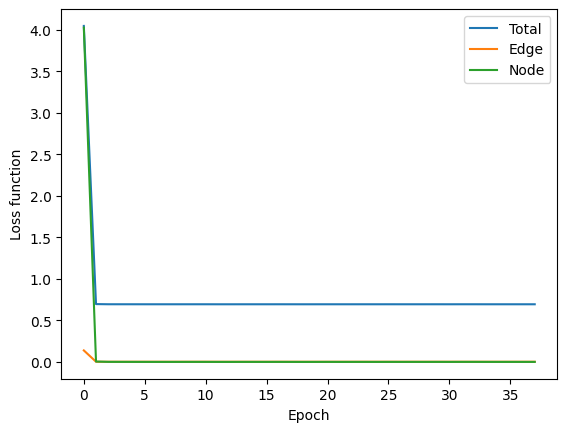

In [23]:
import matplotlib.pyplot as plt 
plt.plot(np.log(total_losses), label='Total')
plt.plot(np.log(edge_losses),  label='Edge')
plt.plot(np.log(node_losses),  label='Node')
plt.xlabel('Epoch')
plt.ylabel('Loss function')
plt.legend(loc='best')
plt.show()